# Estudio de la evolución de la pandemia por el modelo de red neuronal recurrente para la isla de Gran canaria

In [1]:
# Carga inicial de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras import regularizers

In [2]:
def get_X_y(datos, dias):
    
    X, y = [], []
    
    for i in range(len(datos) - dias):
        X.append(datos[i:(i + dias), :])
        y.append(datos[i + dias, 0])
        
    return np.array(X), np.array(y)

def visualizar_pred_test(y_test, y_pred, fechas, tit):
    plt.figure(figsize=(16, 6))
    plt.plot(fechas, y_test, label='Test', color='green')
    plt.plot(fechas, y_pred, label='Predicciones', color='orange')
    plt.xticks(rotation=60)
    plt.xlabel('Fechas')
    plt.ylabel('Número de casos de COVID')
    plt.title(tit)
    plt.legend()
    plt.show()
    
def visualizar_historico(train, test, pred, variable, dias_historico, indices, tit):
    train_s = train.iloc[len(train) - dias_historico:]
    color_isla = 'gray'
    
    plt.figure(figsize=(10, 6))
    if variable != '':
        plt.plot(train_s.index, train_s[variable], label='Train', color=color_isla)
    else:
        plt.plot(train_s.index, train_s, label='Train', color=color_isla)
    plt.plot(indices, y_test, label='Test', color='green')
    plt.plot(indices, y_pred, label='Predicciones', color='orange')
    
    
    plt.xticks(np.arange(0, len(train_s.index)  + len(indices), step=5),   train_s.index.union(indices)[::5], rotation=60)

    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
def obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test):
    modelo = Sequential()
    neurons= X_train.shape[1]
    modelo.add(LSTM(X_train.shape[1] * X_train.shape[2], 
                   activation='relu',
                   return_sequences=True, 
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    modelo.add(Dropout(0.2))
    modelo.add(LSTM(50, 
                   activation='relu',
                   return_sequences=True))
    modelo.add(Dropout(0.2))
    modelo.add(LSTM(25, 
                   activation='relu',
                   return_sequences=False))
    modelo.add(Dropout(0.2))
    #modelo.add(Dense(5, activation='relu'))
    modelo.add(Dense(units=1, kernel_regularizer=regularizers.l2(0.01)))
    modelo.compile(optimizer='rmsprop', loss='mean_squared_error')
    modelo.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)
    
    return modelo
    
def obtener_errores(y_true, y_pred):
    ''' Método que devuelvo los errores:
            * MAE: Error absoluto medio
            * MSE: Error cuadrático medio
            * RMSE: Raíz del error cuadrático medio
    
    Args:
        y_true (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
    Return:
        mae(float): Error absoluto medio
        mse(float): Error cuadrático medio
        rmse(float): Raíz del error cuadrático medio
    '''
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

def visualizar_resultados_texto(y_test, y_pred, fechas):
    for i in range(len(y_test)):
        print(str(fechas[i]) + ': número de casos reales ' + str(int(y_test[i][0])) + ', número de casos predichos ' + str(y_pred[i][0]))

In [3]:
# Cargamos los datos de las estaciones de cada una de las islas
datos = pd.read_csv('../data/Final/datos_final.csv', header=0)
datos_GranCanaria = datos[datos['isla'] == 'GRAN CANARIA']
datos_GranCanaria = datos_GranCanaria.set_index('fecha')

In [4]:
# Variables globales a utilizar en todo el proceso

variables_covid = ['pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19']      # Atributos para el análisis de las variables pandémicas
variables_atm = ['tmin', 'tmed', 'presMax']                              # Atributos para el análisis de las variables atmosféricas
variables = ['pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax']  # Atributos para el análisis de todas las variables


objetivo = 'numero_casos' # Variable objetivo
dias_prediccion = 10      # días a agrupar 
isla = 'Gran Canaria'     # Isla a la que se está realziando el estudio
fechas = datos_GranCanaria.tail(dias_prediccion).index # Fechas de los días a predecir

In [5]:
datos_GranCanaria_uni = datos_GranCanaria[objetivo]
datos_GranCanaria_uni_arr = np.array(datos_GranCanaria_uni).reshape(-1, 1)

datos_GranCanaria_mult_covid = datos_GranCanaria[[objetivo, 'pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19']]
datos_GranCanaria_mult_atm = datos_GranCanaria[[objetivo, 'tmin', 'tmed', 'presMax']]
datos_GranCanaria_mult_total = datos_GranCanaria[[objetivo, 'pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax']]

# Red Neuronal Recurrente univariable

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_GranCanaria_uni_scaled = scaler.fit_transform(datos_GranCanaria_uni_arr)

In [7]:
n_train = len(datos_GranCanaria_uni_scaled) - dias_prediccion


train = datos_GranCanaria_uni_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_GranCanaria_uni_scaled[n_train - dias_prediccion:len(datos_GranCanaria_uni_scaled), :]

In [8]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [9]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50
7/7 [==============================] - 4s 102ms/step - loss: 0.0558 - val_loss: 0.0731
Epoch 2/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0488 - val_loss: 0.0620
Epoch 3/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0445 - val_loss: 0.0534
Epoch 4/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0403 - val_loss: 0.0465
Epoch 5/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0363 - val_loss: 0.0418
Epoch 6/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0313 - val_loss: 0.0466
Epoch 7/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0269 - val_loss: 0.0365
Epoch 8/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0250 - val_loss: 0.0311
Epoch 9/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0225 - val_loss: 0.0324
Epoch 10/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0254 - val_loss: 0.0325
Epoch 11/50
7/7 [===========

In [10]:
test_pred = modelo.predict(X_test)
y_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 435ms/step


In [11]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 533, número de casos predichos 526.02264
2022-03-20: número de casos reales 461, número de casos predichos 525.2638
2022-03-21: número de casos reales 948, número de casos predichos 526.06805
2022-03-22: número de casos reales 966, número de casos predichos 540.2276
2022-03-23: número de casos reales 948, número de casos predichos 603.45917
2022-03-24: número de casos reales 790, número de casos predichos 669.4181
2022-03-25: número de casos reales 741, número de casos predichos 699.7017
2022-03-26: número de casos reales 428, número de casos predichos 733.50055
2022-03-27: número de casos reales 368, número de casos predichos 769.3191
2022-03-28: número de casos reales 528, número de casos predichos 780.7171


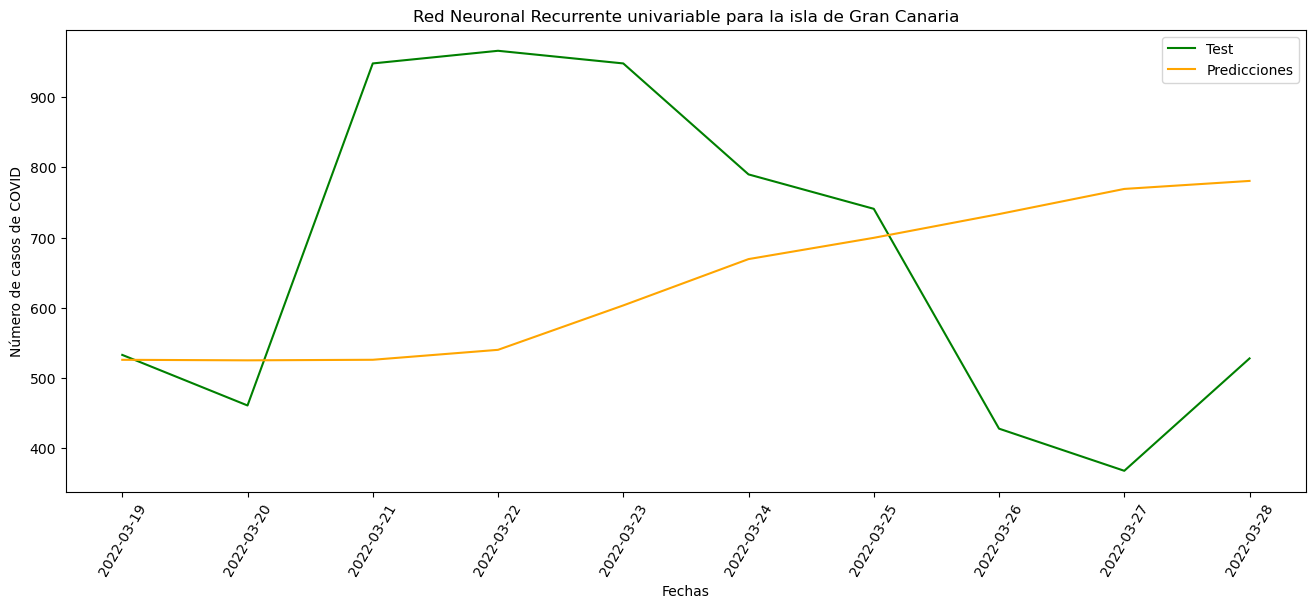

In [12]:
isla = 'Gran Canaria'
fechas = datos_GranCanaria.tail(dias_prediccion).index
tit = 'Red Neuronal Recurrente univariable para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

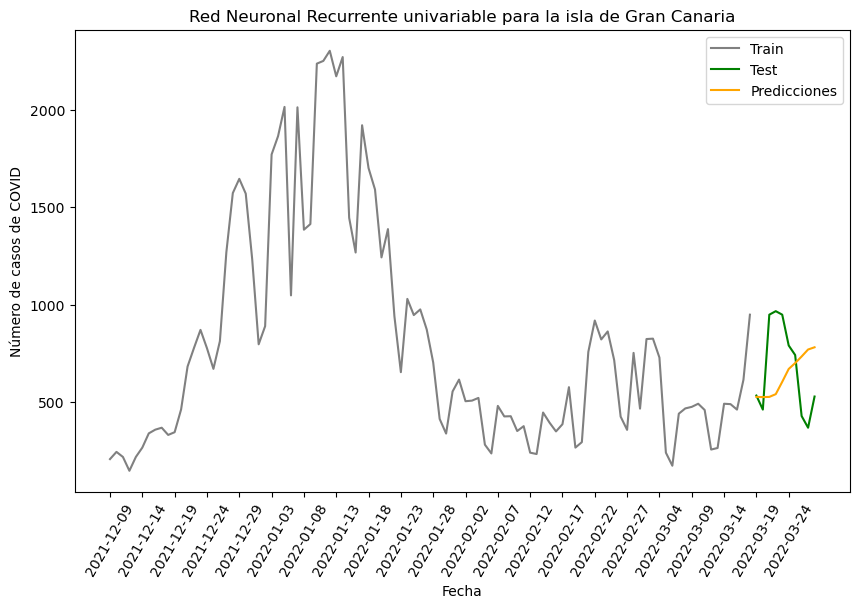

In [13]:
datos_train = datos_GranCanaria_uni.iloc[:n_train]
visualizar_historico(datos_train,y_test,y_pred,'',100,fechas,tit)

In [14]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 81669.46847836934
Error absoluto medio (MAE) del modelo: 238.49032592773438
Raíz del error cuadrático medio (RMSE) del modelo: 285.77870543196417


# Red Neuronal Recurrente multivariable con variables de pandemia

In [15]:
datos_GranCanaria_mult_covid = datos_GranCanaria[[objetivo, 'pcr_total', 'Urg_ingr', 'HPT_cv19', 'CCR_cv19']]
scaler = MinMaxScaler(feature_range=(0, 1))
datos_GranCanaria_mult_covid_scaled = scaler.fit_transform(datos_GranCanaria_mult_covid)

In [16]:
# Escalador para las predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_GranCanaria_mult_covid_scaled_obj = scaler_preds.fit_transform(np.array(datos_GranCanaria_mult_covid[objetivo]).reshape(-1, 1))

In [17]:
n_train = len(datos_GranCanaria_mult_covid_scaled) - dias_prediccion


train = datos_GranCanaria_mult_covid_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_GranCanaria_mult_covid_scaled[n_train - dias_prediccion:len(datos_GranCanaria_mult_covid_scaled), :]

In [18]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [19]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50
7/7 [==============================] - 4s 87ms/step - loss: 0.0557 - val_loss: 0.0618
Epoch 2/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0473 - val_loss: 0.0545
Epoch 3/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0404 - val_loss: 0.0532
Epoch 4/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0332 - val_loss: 0.0566
Epoch 5/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0292 - val_loss: 0.0425
Epoch 6/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0274 - val_loss: 0.0374
Epoch 7/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0260 - val_loss: 0.0422
Epoch 8/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0237 - val_loss: 0.0429
Epoch 9/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0245 - val_loss: 0.0468
Epoch 10/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0229 - val_loss: 0.0460
Epoch 11/50
7/7 [============

In [20]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 322ms/step


In [21]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 533, número de casos predichos 309.65738
2022-03-20: número de casos reales 461, número de casos predichos 329.21863
2022-03-21: número de casos reales 948, número de casos predichos 347.6858
2022-03-22: número de casos reales 966, número de casos predichos 379.6023
2022-03-23: número de casos reales 948, número de casos predichos 419.54794
2022-03-24: número de casos reales 790, número de casos predichos 468.4974
2022-03-25: número de casos reales 741, número de casos predichos 511.44073
2022-03-26: número de casos reales 428, número de casos predichos 547.7211
2022-03-27: número de casos reales 368, número de casos predichos 603.14954
2022-03-28: número de casos reales 528, número de casos predichos 629.94684


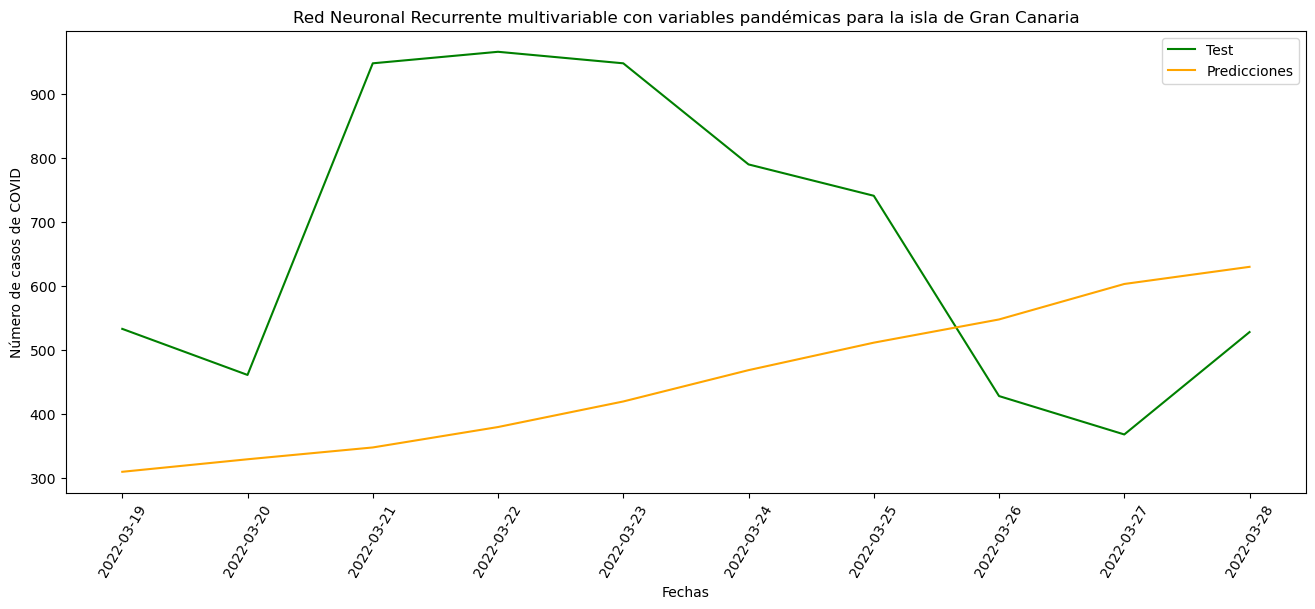

In [22]:
tit = 'Red Neuronal Recurrente multivariable con variables pandémicas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

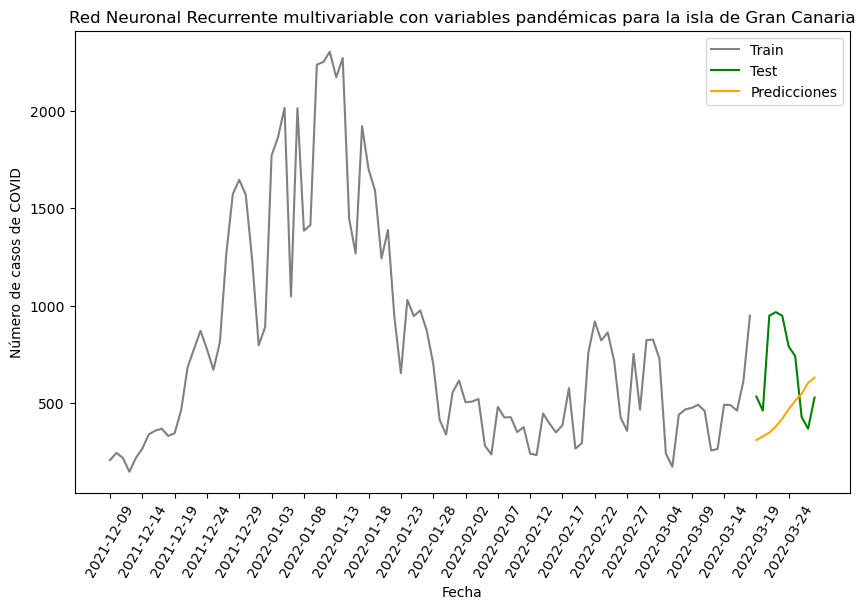

In [23]:
datos_train = datos_GranCanaria_mult_covid.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [24]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 128683.22361792093
Error absoluto medio (MAE) del modelo: 307.8167327880859
Raíz del error cuadrático medio (RMSE) del modelo: 358.7244396719032


# Red Neuronal Recurrente multivariable con variables atmosféricas

In [25]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_GranCanaria_mult_atm_scaled = scaler.fit_transform(datos_GranCanaria_mult_atm)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_GranCanaria_mult_atm_scaled_obj = scaler_preds.fit_transform(np.array(datos_GranCanaria_mult_atm[objetivo]).reshape(-1, 1))

In [26]:
n_train = len(datos_GranCanaria_mult_atm_scaled) - dias_prediccion


train = datos_GranCanaria_mult_atm_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_GranCanaria_mult_atm_scaled[n_train - dias_prediccion:len(datos_GranCanaria_mult_atm_scaled), :]

In [27]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [28]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50
7/7 [==============================] - 3s 82ms/step - loss: 0.0563 - val_loss: 0.0766
Epoch 2/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0477 - val_loss: 0.0594
Epoch 3/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0420 - val_loss: 0.0459
Epoch 4/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0375 - val_loss: 0.0350
Epoch 5/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0336 - val_loss: 0.0307
Epoch 6/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0275 - val_loss: 0.0283
Epoch 7/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0231 - val_loss: 0.0283
Epoch 8/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0260 - val_loss: 0.0276
Epoch 9/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0221 - val_loss: 0.0288
Epoch 10/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0235 - val_loss: 0.0274
Epoch 11/50
7/7 [============

In [29]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 390ms/step


In [30]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 533, número de casos predichos 458.5872
2022-03-20: número de casos reales 461, número de casos predichos 462.28214
2022-03-21: número de casos reales 948, número de casos predichos 472.30038
2022-03-22: número de casos reales 966, número de casos predichos 500.8112
2022-03-23: número de casos reales 948, número de casos predichos 559.48804
2022-03-24: número de casos reales 790, número de casos predichos 618.14905
2022-03-25: número de casos reales 741, número de casos predichos 669.92334
2022-03-26: número de casos reales 428, número de casos predichos 716.2072
2022-03-27: número de casos reales 368, número de casos predichos 745.0759
2022-03-28: número de casos reales 528, número de casos predichos 743.90704


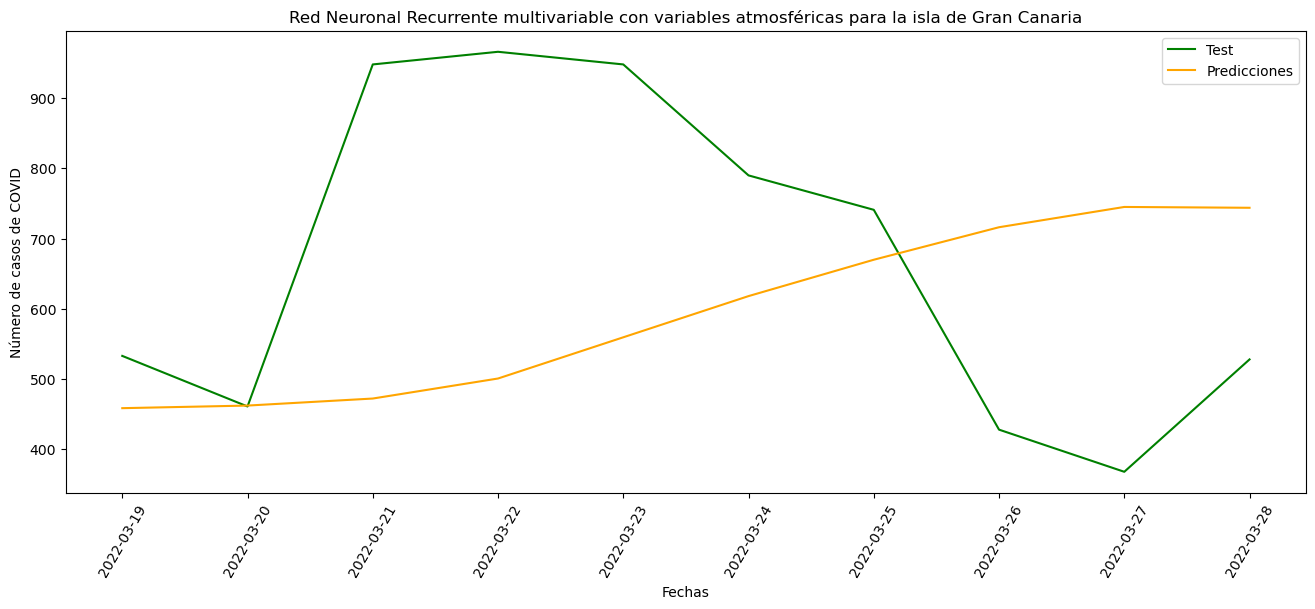

In [31]:
tit = 'Red Neuronal Recurrente multivariable con variables atmosféricas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

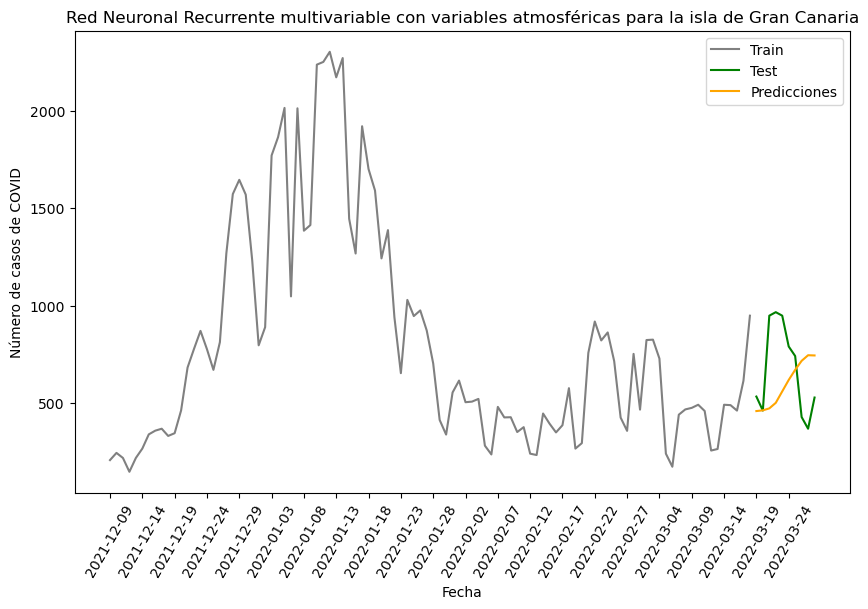

In [32]:
datos_train = datos_GranCanaria_mult_atm.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [33]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 90562.13573471495
Error absoluto medio (MAE) del modelo: 252.9213134765625
Raíz del error cuadrático medio (RMSE) del modelo: 300.9354344950341


# Red Neuronal Recurrente multivariable con todas las variables

In [34]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_GranCanaria_mult_total_scaled = scaler.fit_transform(datos_GranCanaria_mult_total)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_GranCanaria_mult_total_scaled_obj = scaler_preds.fit_transform(np.array(datos_GranCanaria_mult_total[objetivo]).reshape(-1, 1))

In [35]:
n_train = len(datos_GranCanaria_mult_total_scaled) - dias_prediccion


train = datos_GranCanaria_mult_total_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_GranCanaria_mult_total_scaled[n_train - dias_prediccion:len(datos_GranCanaria_mult_total_scaled), :]

In [36]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [37]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50
7/7 [==============================] - 4s 80ms/step - loss: 0.0477 - val_loss: 0.0449
Epoch 2/50
7/7 [==============================] - 0s 19ms/step - loss: 0.0384 - val_loss: 0.0481
Epoch 3/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0314 - val_loss: 0.0381
Epoch 4/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0283 - val_loss: 0.0490
Epoch 5/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0251 - val_loss: 0.0313
Epoch 6/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0256 - val_loss: 0.0424
Epoch 7/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0232 - val_loss: 0.0312
Epoch 8/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0215 - val_loss: 0.0378
Epoch 9/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0219 - val_loss: 0.0410
Epoch 10/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0204 - val_loss: 0.0468
Epoch 11/50
7/7 [============

In [38]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 438ms/step


In [39]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 533, número de casos predichos 392.3792
2022-03-20: número de casos reales 461, número de casos predichos 405.26697
2022-03-21: número de casos reales 948, número de casos predichos 413.02463
2022-03-22: número de casos reales 966, número de casos predichos 439.83362
2022-03-23: número de casos reales 948, número de casos predichos 525.6507
2022-03-24: número de casos reales 790, número de casos predichos 608.0503
2022-03-25: número de casos reales 741, número de casos predichos 650.5251
2022-03-26: número de casos reales 428, número de casos predichos 671.05707
2022-03-27: número de casos reales 368, número de casos predichos 712.803
2022-03-28: número de casos reales 528, número de casos predichos 724.55853


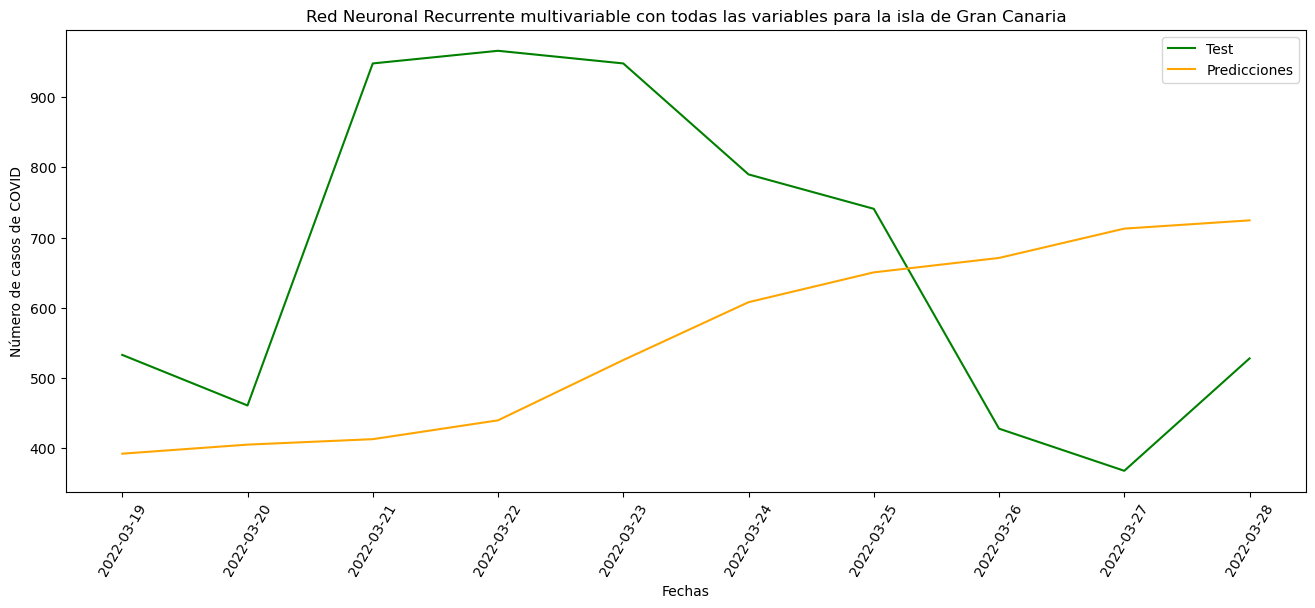

In [40]:
tit = 'Red Neuronal Recurrente multivariable con todas las variables para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

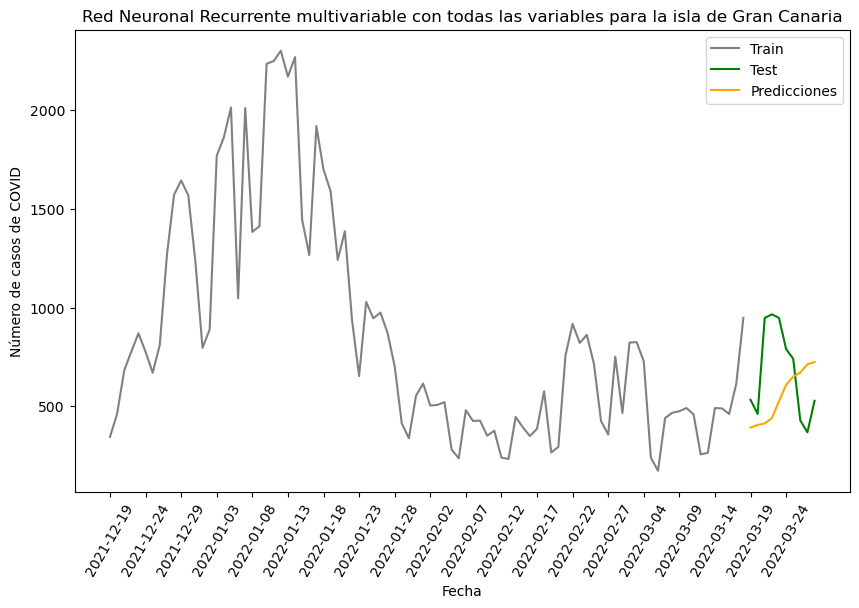

In [41]:
datos_train = datos_GranCanaria_mult_total.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,90,fechas,tit)

In [42]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 102220.1517245357
Error absoluto medio (MAE) del modelo: 273.66880798339844
Raíz del error cuadrático medio (RMSE) del modelo: 319.7188635731957
